In [1]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [2]:
import numpy as np
import os
import nltk
import re
import pickle
from time import time
from gensim import corpora, models, similarities
from itertools import chain
from _datetime import datetime
from lxml import etree
import json
from nltk.corpus import stopwords as sp
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from math import log
from pprint import pprint as pp
from string import punctuation
from collections import defaultdict, deque, OrderedDict
import pandas as pd
import numpy
import logging

C:\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
a = WordNetLemmatizer()
a.lemmatize(word='better', pos='a')

'good'

**Парсинг дат**

In [4]:
from datetime import datetime

def parse_date(date_string, product_list=False):
    # '2009-01-01 08:25:07'
    # 2012-01-17T17:57:00-05:00
    # Friday November 10, 2006 10:49 pm PST
    # November 2, 2012 - product list
    if not product_list:
        if 'T' not in date_string:
            date = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S').date()
        elif 'pst' in date_string.lower() or 'pdt' in date_string.lower():
            date = datetime.strptime(date_string[:-4], '%A %B %d, %Y %H:%M %p').date()
        else:
            date = datetime.strptime(date_string[:-6], '%Y-%m-%dT%H:%M:%S').date() 
    else:
        date = datetime.strptime(date_string, '%B %d, %Y').date()
    return date

def parse_dates(dates):
    return [parse_date(date) for date in dates]

**Препроцессинг**

In [5]:
def read_data(filename):
    data = pd.read_excel(filename)
    return data

with open('.\english_stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = [word.strip('\n') for word in f.readlines()]
# stopwords = list(set(sp.words('english') + stopwords))
# lemmatizer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
numbers = re.compile('[0-9]')
punctuation += '\n—–- «»\'\"'
lemmatization_stoplist = ['3gs', '4s', '5s', '6s']
product_lemm_reg = re.compile("(iphone|ipad|ipod|macbook|[ie]mac|air|5c|classic|nano|tv|ibook|shuffle|touch|mini|pro|powerbook)(s|es)")

def lemmatize(text, allow_stopwords=False):
    if allow_stopwords:
        current_stopwords = []
    else:
        current_stopwords = stopwords[:]
    lemmatized = [lemmatizer.lemmatize(word).lower() 
                  if not word in lemmatization_stoplist else word.lower() 
                  for word in nltk.word_tokenize(text) 
                    if word.lower() not in current_stopwords + list(punctuation) and (numbers.search(word) is None or word in lemmatization_stoplist)
                    and word not in ["''", ' ', '``', '', "'s"]
                 ]
    product_lemmatized = [product_lemm_reg.sub('\\1', word) for word in lemmatized]
    return product_lemmatized

def preprocess_text(text, split=None, allow_stopwords=False):
    if split == 'sentence':
        sentences = nltk.sent_tokenize(text)
        return [lemmatize(sent, allow_stopwords) for sent in sentences]
    elif split == 'paragraph_sentence':
        try:
            paragraphs = [nltk.sent_tokenize(par) for par in re.split('[\r\n]{2,}', text) if not par.strip() == '']
        except:
            print(text)
        return [[lemmatize(sent, allow_stopwords) for sent in sents if not sent.strip() == ''] for sents in paragraphs]
    elif split == 'paragraph':
        paragraphs = [lemmatize(par, allow_stopwords) for par in re.split('[\r\n]{2,}', text)]
        return paragraphs
    else:
        return lemmatize(text)

def pickle_serialize(obj, filename):
    with open(filename, 'wb') as f:
        f.write(pickle.dumps(obj))    
    
def make_corpus(filename, serialize=None):
    data = read_data(filename)
    dates = parse_dates(data['datetime'])
    preprocessed_docs =  [[id, date, preprocess_text(body, split='paragraph_sentence')] for (id, body), date in zip(enumerate(list(data['body'])), dates) if not pd.isnull(body) and not body.strip() == '']
    if serialize:
        pickle_serialize(preprocessed_docs, serialize)
    return preprocessed_docs

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.loads(f.read())

Загрузим и предобработаем все корпуса. 
Затем склеим их в один большой корпус, чтобы построить по нему тематическую модель.

In [6]:
combined_corpus = defaultdict(list)
[combined_corpus[date].append(pars) for id, date, pars in load_pickle('./DATA/AppleInsiderLemmatized.pickle')]
[combined_corpus[date].append(pars) for id, date, pars in load_pickle('./DATA/MacRummorsLemmatized.pickle')]
[combined_corpus[date].append(pars) for id, date, pars in load_pickle('./DATA/NineToFiveMacLemmatized.pickle')]
id, cc, all_docs, cc_corpus, cc_sent_par_corpus = 0, [], [], [], []
for date, docs in sorted(combined_corpus.items(), key=lambda x: x[0]):
    for pars in docs:
        cc_sent_par_corpus.append([id, date, pars])
        cur_doc, cur_corp = [], []
        for par in pars:
            flat_par = list(chain(*par))
#             cc.append(flat_par)
            cur_doc.extend(flat_par)
#             cur_corp.append(flat_par)
        all_docs.append(cur_doc)
#         cc_corpus.append([id, date, cur_corp])
        id += 1
del(combined_corpus)

**Подготавливаем данные для построения тематической модели**

In [7]:
from itertools import chain

def make_batches(corpus ,test=False):
    if test:
        first_batch_len = 100
    else:
        first_batch_len = 2000
    batch_id = 0
    batches = []
    prev_date = corpus[0][1]
    current_batch = []
    for id, date, paragraphs in corpus:
        if batch_id != 0:
            current_batch.extend([list(chain(*sents)) for sents in paragraphs])
            if len(current_batch) >= 30:
                batches.append([date, current_batch])
                current_batch = []
        else:
            if len(current_batch) < first_batch_len:
                current_batch.extend([list(chain(*sents)) for sents in paragraphs])
            else:
                prev_date = date
                batch_id += 1
    return batches

def make_dictionary(texts, test=False):
    dictionary = corpora.Dictionary(texts)
    if test:
        dictionary.filter_extremes(no_below=1, no_above=1000, keep_n=None)
    else:
        dictionary.filter_extremes(no_below=20, no_above=0.5, keep_n=None)
    print(dictionary)
    return  dictionary

def make_bow_texts(batch, dictionary):
    bow_texts = [dictionary.doc2bow(text) for text in batch]
    return bow_texts

In [8]:
# cc_dict = make_dictionary(all_docs)
# cc_bows = make_bow_texts(cc, cc_dict)

**Считаем распределение топиков во времени**

In [9]:
def load_topic_models(directory):
    from datetime import datetime
    models_dict = {}
    for filename in os.listdir(directory):
        if '.' not in filename:
            date = datetime.strptime(filename, '%Y-%m-%d').date()
            models_dict[date] = os.path.join(directory, filename)
    return models_dict

# models_dict = load_topic_models('test_model')
# models_dict

In [10]:
def load_model(filename):
    return models.LdaMulticore.load(filename)

#     return [([id2word[id] for id in model.get_topic_terms(topic)], prob) for topic, prob in topics]
    
def get_topic_distributions(dictionary, data, model_dict):
    import datetime
    print('start gathering')
    models_dates = list(model_dict.keys())
    topic_by_date_counts = defaultdict(lambda: defaultdict(int))
    date_by_topic_counts = defaultdict(lambda: defaultdict(int))
    current_model_date = min(models_dates)
    model = load_model(model_dict[current_model_date])
    print('model loaded')
    for id, date, paragraphs in data:
        if date <= max(models_dates) and date <= datetime.date(2009, 1, 27):
            cur_topics = defaultdict(int)
            min_model_date = min([d for d in models_dates if d >= date])
            if current_model_date < min_model_date:
                model = load_model(model_dict[min_model_date])
                current_model_date = min_model_date
                print(current_model_date)
            par_bows = [dictionary.doc2bow(list(chain(*par))) for par in paragraphs]
            for bow in par_bows:
                topics = model.get_document_topics(bow, minimum_probability=0.5)
                for topic, prob in sorted(topics, key=lambda  x: -x[1])[:5]:
                    topic_terms = '+'.join([w for w, p in model.show_topic(topic, 5)])
                    cur_topics[topic_terms] += 1  # ID топиков со временем меняются, поэтому используем слова в к-ве id
            if cur_topics:
                doc_topics = sorted(cur_topics.items(), key=lambda x: -x[1])[:5]
                print(doc_topics)
                for topic, prob in doc_topics:
                    topic_by_date_counts[date][topic] += 1
                    date_by_topic_counts[topic][date] += 1
            
    return topic_by_date_counts, date_by_topic_counts
        
# tbd, dbt = get_topic_distributions(test_dict, test_corpus,  models_dict)
# dbt

def get_topics(tokenized_text, date, model_dict, id2word, threshold=0.1):
    models_dates = list(model_dict.keys())
    min_model_date = min([d for d in models_dates if d >= date])
#     print(min_model_date)
    model = load_model(model_dict[min_model_date])
#     print(model)
    bow = id2word.doc2bow(tokenized_text)
    topics = model.get_document_topics(bow, minimum_probability=threshold)
    model.id2word = id2word
    return [('+'.join([w for w, p in model.show_topic(topic)]), prob) for topic, prob in topics]    
    
text = """
"Fortune summarizes a pair of analyst reports out today suggesting that Apple may be experiencing some supply constraints on the iPhone 4S during this holiday quarter.  The company has obviously been working hard to demand for the device as shipping estimates through iPhone carrier partners and even Apple itself have at times been lengthy, but beyond high demand the new reports suggest that Apple may be having some trouble meeting its own production goals for the device.
 the reason behind his reduction in quarterly iPhone sales of about three million units, moving from 26-28 million units to 23-25 million units.  He notes that demand appears to remain strong but that Apple is having a hard time producing enough iPhones to meet that demand.Related Roundup: iPhone 6s Tags: Rodman and Renshaw, Ashok Kumar, Susquehanna, Jeff Fidacaro Buyer's Guide: iPhone (Neutral) "

"""
# get_topics(preprocess_text(text), datetime.date(2011, 11, 29), time_model_dict, time_model_id2word, 0.001)

**Подготовим данные для построения "классификатора утечек"**

Для начала загрузим модель, построенную на всей коллекции с трех сайтов

In [11]:
# mcr_model = models.LdaModel.load('./topic_models/models/400_topics.model')
# mcr_dict = corpora.Dictionary.load('./topic_models/models/400_topics.model.id2word')
# mcr_model.id2word = mcr_dict
# all_bows = make_bow_texts(all_docs, mcr_dict)
# cc_bows = make_bow_texts(cc, mcr_dict)

Посмотрим какие топики получились

In [12]:
# for id, words in mcr_model.show_topics(600, 20, formatted=False):
#     print(id, [word for word, prob in words])

Сделаем функцию, которая отфильтровывает документы,  в которых встретилсь топики с заданными номерами и записывает их в файл

In [13]:
def find_topics(filename, model, doc_bow, docs, topic_id_list):
    filtered_docs = []
    topic_id_list = set(topic_id_list)
    wiritten = 0
    i = 0
    for bow in log_progress(doc_bow):
#         if i and i % 1000 == 0: 
#             print(i)
        cur_topics = model.get_document_topics(bow, minimum_probability=0.1)
        cur_topic_ids = set([id for id, prob in cur_topics])
        intersection = topic_id_list.intersection(cur_topic_ids)
        if intersection:
            best_topic = list(max([(id, prob) for id , prob in cur_topics if id in intersection], key=lambda x: -x[1]))
            filtered_docs.append([i, ' '.join(docs[i])] + best_topic) 
        i += 1
    pd.DataFrame(sorted(filtered_docs, key=lambda x: -x[-1])).to_excel(filename, index=False, header=['id', 'text', 'best_topic_id', 'probability'])

Найдем такие документы в macrummors. Просмотр топиков показал, что топики с таким смыслом это [334, 350, 148, 126, 52, 182, 216, 94, 170]

In [14]:
# find_topics('mcr_leaks_data_full_docs.xlsx', mcr_model, all_bows, all_docs, [334, 350, 148, 126, 52, 182, 216, 94, 170])
# keynotes and announcements topics: 216, 94, 170

Теперь надо собрать набор документов, не являющихся утечкамии

In [15]:
leak_data = pd.read_excel('./topic_models/mcr_leaks_data_full_docs.xlsx')
leak_data= leak_data.loc[leak_data['best_topic_id'].isin([334, 350, 126, 52])]
leak_data['class'] = 1

In [16]:
leak_data_filtered = leak_data.loc[(leak_data['probability']<0.6), ['text', 'class']]
leak_data_filtered.shape

(3860, 2)

In [17]:
leaks_ids = leak_data.id
# non_leak_data = pd.DataFrame([[' '.join(par), 0] for i, par in enumerate(cc) if not i in leaks_ids], columns=['text', 'class'])
non_leak_data = pd.DataFrame([[' '.join(par), 0] for i, par in enumerate(all_docs) if not i in leaks_ids], columns=['text', 'class'])
non_leak_data.shape

(54209, 2)

In [18]:
df = pd.concat([leak_data_filtered, non_leak_data.sample(frac=0.06)])
df = df.sample(frac=1).reset_index(drop=True)
df.head()
del(leak_data, leak_data_filtered, non_leak_data)

In [19]:
X = [t if not pd.isnull(t) else '' for t in list(df['text'])]
y = df['class']
# assert X.shape == y.shape
# X.shape, y.shape

**Построим классификтор утечек**

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BaseNB, BernoulliNB
from sklearn.svm import SVC

In [21]:
leaks_vectorizer = TfidfVectorizer()
X_tfidf = leaks_vectorizer.fit_transform(X)
del(X)

In [22]:
clf = LogisticRegression(verbose=1,solver='liblinear')
y_pred = cross_val_predict(clf, X_tfidf, y, verbose=1, cv=4)
print(classification_report(y, y_pred))

[LibLinear][LibLinear][LibLinear][LibLinear]             precision    recall  f1-score   support

          0       0.85      0.85      0.85      3253
          1       0.87      0.87      0.87      3860

avg / total       0.86      0.86      0.86      7113



[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s finished


In [23]:
leaks_classifier = LogisticRegression(solver='liblinear')
leaks_classifier.fit(X_tfidf, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
def is_leak(text, preprocess=False):
    if preprocess:
        text = preprocess_text(text)
    tf_idf_text = leaks_vectorizer.transform([' '.join(text)])
    return leaks_classifier.predict(tf_idf_text)[0]

is_leak('report says that', preprocess=True)

1

**Теперь функции для поиска упоминаний продуктов в текстах**

In [25]:
import re
def make_product_tuple(product_full_name):
    name_cleaned = ''.join([char for char in product_full_name.lower() if not char in '()\'"&']).split()
    parts_to_remove = ['gb', '+', 'with', 'wcdma', 'cdma', 'gsm', '16', '32', '64', '128']
    name_cleaned = tuple([re.sub('([0-9])(rd|st|nd|th)', '\\1', word) for word in name_cleaned if not word in parts_to_remove])
    return name_cleaned

def make_product_regex(product_full_name, min_req):
    product_tuple = make_product_tuple(product_full_name)
    product_regex = ''
    for i in range(len(product_tuple)):
        if i < min_req:
            product_regex += '\ ({})'.format(product_tuple[i])
        else:
            product_regex += '(\ *{})?'.format(product_tuple[i])
    modifiers = """(?P<new_products>  # a group for the words reffering to new and upcoming products
            new(?:est)?|(?:up)?coming|to\ *?be\ *?ann?ounced|updated?|
            (next\ *?-?\ *?(?:gen(?:eration)?|year)?)
       )?
       (?P<launched_products> # a group for the words reffering to the old or already launched products
           (?: (current|last|previous)\ *?-?\ *?(?:gen(?:eration)?|year)?)
           |(?:this\ *?-?\ *?(?:gen(?:eration)?|year)?)
       )?\ *?"""
    product_regex = modifiers + product_regex.strip()
    return re.compile(product_regex.strip(), re.X)

def read_product_list(product_list_file):
    models = defaultdict(lambda: defaultdict(list))
    model2family = {}
    product_list = read_data(product_list_file)
    for i, (year, launched, date_launched, model_full, keywords, inter_req, model_group, family) in product_list.iterrows():
        product = make_product_regex(keywords, inter_req)
        date = parse_date(date_launched, True)
        model_group = ' '.join(model_group.split())
        model2family[model_group] = family
        if not product in models[date][model_group]:
            models[date][model_group].append((product, inter_req))
    return models, model2family

In [26]:
from datetime import datetime

def find_mention(tokenized_text, regex):
    text_string = ' '.join(tokenized_text)
    matches = regex.finditer(text_string)
    return matches

def delete_intersections(product_mentions):
    pm = sorted(product_mentions, key=lambda x: (x[2].start(), -x[2].end()))
    first_mention = pm[0]
    filtered = [first_mention]
    p_product, p_launch_date, (p_start, p_end) = first_mention[0], first_mention[1], first_mention[2].span()
    for mention in pm[1:]:
        product, launch_date, (start, end) = mention[0], mention[1], mention[2].span()
        last_added_span = tuple(filtered[-1][-1].span())
        if product != p_product and (end > p_end or start > p_end or (start, end) == last_added_span):
            filtered.append(mention)
    return filtered

def sort_by_date(product_mentions, article_date):
    launched_products =  []
    upcoming_products =  []
    for mention in product_mentions:
        product, launch_date, match = mention
        has_new_word = match.group('new_products')
        has_launched_word = match.group('launched_products')
        if launch_date >= article_date:
            if not has_launched_word and has_new_word:
                upcoming_products.append(mention)
        elif launch_date < article_date:
            if not has_new_word and has_launched_word:
                launched_products.append(mention)
            else:
                if (article_date - launch_date).days < 50 and has_new_word:
                    upcoming_products.append(mention)
    return launched_products, upcoming_products

def get_unique_mentions(mentions):
    return list(set([m[0] for m in mentions]))

def get_earliest(mentions, m2f):
    family2model = defaultdict(list)
    for mention in mentions:
        if mention:
#             print(mention[0])
            family = m2f[mention[0]]
            family2model[family].append(mention)
    earliest = [min(mentions, key=lambda x: x[1]) for family, mentions in family2model.items()]
    return earliest
        
def search_products(tokenized_sents, product_list, article_date):
    marked_text = ''
    launched_products =  []
    upcoming_products =  []
    for sent in tokenized_sents:
        mentions = []
        for launch_date in product_list:
            if -365 < (article_date - launch_date).days < 365:
                for product, regexs in product_list[launch_date].items():
                    for regex, _ in regexs:
                        search_results = find_mention(sent, regex)  
                        mentions.extend([[product, launch_date] + [sr] for sr in search_results])
        if mentions:
            mentions = delete_intersections(mentions)
            cur_launched_products, cur_upcoming_products = sort_by_date(mentions, article_date)
            launched_products.extend(cur_launched_products)
            upcoming_products.extend(cur_upcoming_products)
    return launched_products, upcoming_products

# import datetime

# launched, upcoming = search_products(preprocess_text('This new iphone is just amazing and the new imac', split='sentence'), apple_product_list, datetime.date(2009, 2, 23))
# print(upcoming)
# get_earliest(upcoming, apple_m2f)

Наш список продуктов

In [27]:
from datetime import datetime, date as ddate
apple_product_list, apple_m2f = read_product_list('.\\DATA\\Apple_produt_list_withour_dicsontinuation.xlsx')

def find_apple_products(tokenized_sents, article_date):
    return [get_earliest(i, apple_m2f) for i in search_products(tokenized_sents, apple_product_list, article_date)]
apple_product_list

defaultdict(<function __main__.read_product_list.<locals>.<lambda>>,
            {datetime.date(2000, 2, 16): defaultdict(list,
                         {'PowerBook ("Pismo")': [(re.compile(r'(?P<new_products>  # a group for the words reffering to new and upcoming products\n            new(?:est)?|(?:up)?coming|to\ *?be\ *?ann?ounced|updated?|\n            (next\ *?-?\ *?(?:gen(?:eration)?|year)?)\n       )?\n       (?P<launched_products> # a group for the words reffering to the old or already launched products\n           (?: (current|last|previous)\ *?-?\ *?(?:gen(?:eration)?|year)?)\n           |(?:this\ *?-?\ *?(?:gen(?:eration)?|year)?)\n       )?\ *?\ (powerbook)\ (pismo)',
                            re.UNICODE|re.VERBOSE),
                            3)]}),
             datetime.date(2000, 7, 19): defaultdict(list,
                         {'Power Mac G4 Cube': [(re.compile(r'(?P<new_products>  # a group for the words reffering to new and upcoming products\n            new(?:es

**Анализ тональности**

In [28]:
from scipy.sparse import hstack
from pprint import pprint as pp
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import  TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.cross_validation import  cross_val_score, cross_val_predict
from sklearn.metrics import classification_report
from nltk.corpus import stopwords as sp
from nltk.stem import SnowballStemmer
from string import punctuation

In [29]:
stemmer = SnowballStemmer('english')

def stem(text):
    tokens = [word.strip(punctuation) for word in text.lower().split() if not word in stopwords]
    stems = [stemmer.stem(token) for token in tokens]
    return stems

In [30]:
print('Reading data...')
df_iphones = pd.read_csv('./DATA/Amazon.csv')
df_laptops = pd.read_csv('./DATA/AmazonAppleLaptops.csv')
df_ipads = pd.read_csv('./DATA/AmazonAppleiPads.csv')
df_macs = pd.read_csv('./DATA/AmazonAppleMacs.csv')
df = pd.concat([df_iphones, df_laptops, df_ipads, df_macs])

print('Preprocessing...')
texts = [stem(text) if not pd.isnull(text) else [''] for text in list(df.body)]

print('Making tf-idf...')
# vectorizer = TfidfVectorizer(lowercase=False, max_df=0.4, min_df = 20)
SA_vectorizer = TfidfVectorizer(lowercase=False, max_df=0.4, min_df = 20, ngram_range=(1,4), use_idf=False)
# vectorizer = CountVectorizer(lowercase=False, max_df=0.4, min_df = 20, ngram_range=(1,4), binary=True)
X = SA_vectorizer.fit_transform([' '.join(text) for text in texts])
y = [1 if int(star[0]) >= 4 else 0 for star in df.stars]

#     clf = RandomForestClassifier(n_estimators=100, verbose=1, n_jobs=4)

Reading data...
Preprocessing...
Making tf-idf...


In [31]:
SA_clf = LogisticRegression()
SA_clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
def get_sentiment(text, preprocess=False):
    if preprocess:
        text = stem(text)
    return SA_clf.predict(SA_vectorizer.transform([' '.join(text)]))[0]

# get_sentiment('This iphone is bad', preprocess=)

**Выделение аттрибутов устройств**

In [33]:
with open('product_attributes_taxonomy.txt', 'r', encoding='utf-8') as f:
    taxonomy_text = f.read()

In [34]:
import json
import pickle
from pprint import pprint as pp
from collections import defaultdict as dd, OrderedDict as od
import re

taxonomy = od()
prev_tab_level = 0
parent = ''
prev_line = ''
path = []
for line in taxonomy_text.split('\n'):
    line = line.strip(' ')
    tab_level = line.count('\t')
    if tab_level > prev_tab_level:
        path.append(parent)    
        parent = prev_line.split()[0]
    elif tab_level < prev_tab_level:
        parent = path[tab_level - prev_tab_level]
        path = path[:tab_level - prev_tab_level]
    for word in line.strip('\t').split(' '):
        if not tab_level == 0:
            taxonomy[tuple(word.lower().split('-'))] = path[1:] + [parent]
        else:
            taxonomy[tuple(word.lower().split('-'))] = [line.split()[0]]
    prev_line = line
    prev_tab_level = tab_level

pp((taxonomy))

with open('product_attributes_taxonomy.pickle', 'wb') as f:
    f.write(pickle.dumps(taxonomy))


OrderedDict([(('screen',), ['SCREEN']),
             (('display',), ['SCREEN']),
             (('type',), ['SCREEN', 'DISPLAY']),
             (('led',), ['SCREEN', 'DISPLAY', 'TYPE']),
             (('oled',), ['SCREEN', 'DISPLAY', 'TYPE', 'LED']),
             (('lcd',), ['SCREEN', 'DISPLAY', 'TYPE']),
             (('tft',), ['SCREEN', 'DISPLAY', 'TYPE', 'LCD']),
             (('ips',), ['SCREEN', 'DISPLAY', 'TYPE', 'LCD']),
             (('resolution',), ['SCREEN', 'DISPLAY']),
             (('960x640',), ['SCREEN', 'DISPLAY', 'RESOLUTION']),
             (('1136x640',), ['SCREEN', 'DISPLAY', 'RESOLUTION']),
             (('1335x750',), ['SCREEN', 'DISPLAY', 'RESOLUTION']),
             (('1920x1080',), ['SCREEN', 'DISPLAY', 'RESOLUTION']),
             (('1048x768',), ['SCREEN', 'DISPLAY', 'RESOLUTION']),
             (('2048x1535',), ['SCREEN', 'DISPLAY', 'RESOLUTION']),
             (('inch', 'size'), ['SCREEN', 'DISPLAY']),
             (('3,5',), ['SCREEN', 'DISPLAY', 'INCH-SI

In [35]:
def make_regex(taxonomy_dict):
    regex = ''
    for entry in sorted(taxonomy_dict.keys(), key=lambda x: (x[0], -len(x))):
        regex += '[ -]+'.join(entry) + '|'
    return re.compile(regex.strip('|'))

product_feature_regex = make_regex(taxonomy)
product_feature_regex.findall('The battery life and the picture quality of the camera sensor as well as the display ppi')

['battery life', 'picture quality', 'camera', 'sensor', 'display', 'ppi']

In [36]:
def get_taxonomy_paths(text, regex, taxonomy):
    taxonomy_paths = []
    search_results = regex.findall(text)
    for sr in search_results:
        taxonomy_paths.append(taxonomy[tuple(re.split('[- ]+', sr))])
    return taxonomy_paths

get_taxonomy_paths('The battery life and the picture quality of the camera sensor as well as the display ppi', product_feature_regex, taxonomy)

[['BATTERY'],
 ['CAMERA'],
 ['CAMERA'],
 ['CAMERA'],
 ['SCREEN'],
 ['SCREEN', 'DISPLAY', 'PIXEL-DENSITY']]

In [37]:
def get_apple_features(text):
    if type(text) == list:
        text = ' '.join(text)
    return get_taxonomy_paths(text, product_feature_regex, taxonomy)

get_apple_features('The battery life and the picture quality of the camera sensor as well as the display ppi')

[['BATTERY'],
 ['CAMERA'],
 ['CAMERA'],
 ['CAMERA'],
 ['SCREEN'],
 ['SCREEN', 'DISPLAY', 'PIXEL-DENSITY']]

**Собираем все вместе**

In [38]:
time_model_dict = load_topic_models('./topic_models/time_model_2013_2014')
time_model_id2word = corpora.Dictionary.load('./topic_models/time_model_2013_2014/time_model_2013_2014.dict')
time_model_dict

{datetime.date(2013, 1, 9): './topic_models/time_model_2013_2014\\2013-01-09',
 datetime.date(2013, 1, 16): './topic_models/time_model_2013_2014\\2013-01-16',
 datetime.date(2013, 1, 23): './topic_models/time_model_2013_2014\\2013-01-23',
 datetime.date(2013, 1, 30): './topic_models/time_model_2013_2014\\2013-01-30',
 datetime.date(2013, 2, 6): './topic_models/time_model_2013_2014\\2013-02-06',
 datetime.date(2013, 2, 13): './topic_models/time_model_2013_2014\\2013-02-13',
 datetime.date(2013, 2, 20): './topic_models/time_model_2013_2014\\2013-02-20',
 datetime.date(2013, 2, 27): './topic_models/time_model_2013_2014\\2013-02-27',
 datetime.date(2013, 3, 6): './topic_models/time_model_2013_2014\\2013-03-06',
 datetime.date(2013, 3, 13): './topic_models/time_model_2013_2014\\2013-03-13',
 datetime.date(2013, 3, 20): './topic_models/time_model_2013_2014\\2013-03-20',
 datetime.date(2013, 3, 27): './topic_models/time_model_2013_2014\\2013-03-27',
 datetime.date(2013, 4, 3): './topic_models

In [39]:
text = ''
class Event:
    def __init__(self, article, start_date):
        self.start_date =  start_date
        self.end_date = self.start_date
        self.articles = [article]
        self.features = defaultdict(lambda: defaultdict(int))
        self.overall_sentiment = defaultdict(int)
        self.get_features_sentiment(article)
        
    def add_article(self, article, date):
        self.articles.append(article)
        self.get_features_sentiment(article)
        self.end_date = date
        
    def get_features_sentiment(self, text):
        for sentence in list(chain(*text)):
#             sd = {1:1, 0:-1}
            sentiment = get_sentiment(' '.join(sentence), preprocess=True)
            features = get_apple_features(' '.join(sentence))
            for feature in features:
                self.features[feature[0]][sentiment] += 1
                self.overall_sentiment[sentiment] += 1
                
ev = Event(preprocess_text("The display quality and the battery on this phone is just amazing. But the design is bad. \n\n And the battery is great.", split='paragraph_sentence'), '123')
ev.add_article(preprocess_text("I do like the camera, but the sensor is terrible and the glass is easy to shatter", split='paragraph_sentence'), '234')
ev.features
# ev.overall_sentiment

defaultdict(<function __main__.Event.__init__.<locals>.<lambda>>,
            {'BATTERY': defaultdict(int, {1: 2}),
             'CAMERA': defaultdict(int, {1: 2}),
             'DESIGN': defaultdict(int, {1: 1}),
             'SCREEN': defaultdict(int, {1: 1}),
             'SOFTWARE': defaultdict(int, {0: 1})})

In [40]:
import datetime

def merge_topics(product_topics, current_topic):
    current_topic_words = set(current_topic.split('+'))
    for topic in product_topics.keys():
        topic_words = set(topic.split('+'))
        if len(topic_words.intersection(current_topic_words)) / len(topic_words) >= 0.6:
            return topic
    return current_topic

def collect_data(corpus, time_model_dict, id2word):
    product_data = defaultdict(lambda: defaultdict(lambda: defaultdict()))
    for id, article_date, doc in log_progress(corpus):
        sents = list(chain(*doc))
        flat_doc = list(chain(*sents))
        if is_leak(flat_doc):
            for par in doc:
                lpm, upm = find_apple_products(par, article_date)
                topics = get_topics(list(chain(*par)), article_date, time_model_dict, id2word, 0.1)
                if topics:
#                     pp(topics)
                    topic = max(topics, key=lambda x: -x[1])[0]
#                     print(topic)
                    for product in get_unique_mentions(upm):
                        new_topic = merge_topics(product_data[product], topic)
                        if new_topic not in product_data[product]:
                            product_data[product][new_topic] = Event(doc, article_date)
                        else:
                            if doc not in product_data[product][new_topic].articles:
                                product_data[product][new_topic].add_article(doc, article_date)
    return product_data

In [41]:
data = collect_data([i for i in cc_sent_par_corpus if datetime.date(2013, 9, 1) <i[1]< datetime.date(2013, 11, 1)], time_model_dict, time_model_id2word)            
data

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


defaultdict(<function __main__.collect_data.<locals>.<lambda>>,
            {'Mac Mini (Late 2014)': defaultdict(<function __main__.collect_data.<locals>.<lambda>.<locals>.<lambda>>,
                         {'mini+available+launch+sale+could+million+month+report+product+expected': <__main__.Event at 0x65bb6a58>}),
             'Mac Pro (Late 2013)': defaultdict(<function __main__.collect_data.<locals>.<lambda>.<locals>.<lambda>>,
                         {'apple’s+||+.push+adsbygoogle+window.adsbygoogle+controller+below+flagship+weekend+sport': <__main__.Event at 0x65bb6f28>,
                          'data+were+next+customer+about+mobile+may+still+surface+number': <__main__.Event at 0x65bb7048>,
                          'event+os+radio+right+building+revealed+experience+setting+detail+instead': <__main__.Event at 0x65bb6550>,
                          'launch+available+could+mini+sale+report+product+million+month+expected': <__main__.Event at 0x65bb3940>,
                          '

In [42]:
colors = ["Blue", "BlueViolet", "Brown", "BurlyWood", "CadetBlue", "Chartreuse", "Chocolate", "Coral", "CornflowerBlue", "Cornsilk", "Crimson", "Cyan", "DarkBlue", "DarkCyan", "DarkGoldenRod", "DarkGray", "DarkGrey", "DarkGreen", "DarkKhaki", "DarkMagenta", "DarkOliveGreen", "DarkOrange", "DarkOrchid", "DarkRed", "DarkSalmon", "DarkSeaGreen", "DarkSlateBlue", "DarkSlateGray", "DarkSlateGrey", "DarkTurquoise", "DarkViolet", "DeepPink", "DeepSkyBlue", "DimGray", "DimGrey", "DodgerBlue", "FireBrick", "FloralWhite", "ForestGreen", "Fuchsia", "Gainsboro", "GhostWhite", "Gold", "GoldenRod", "Gray"]

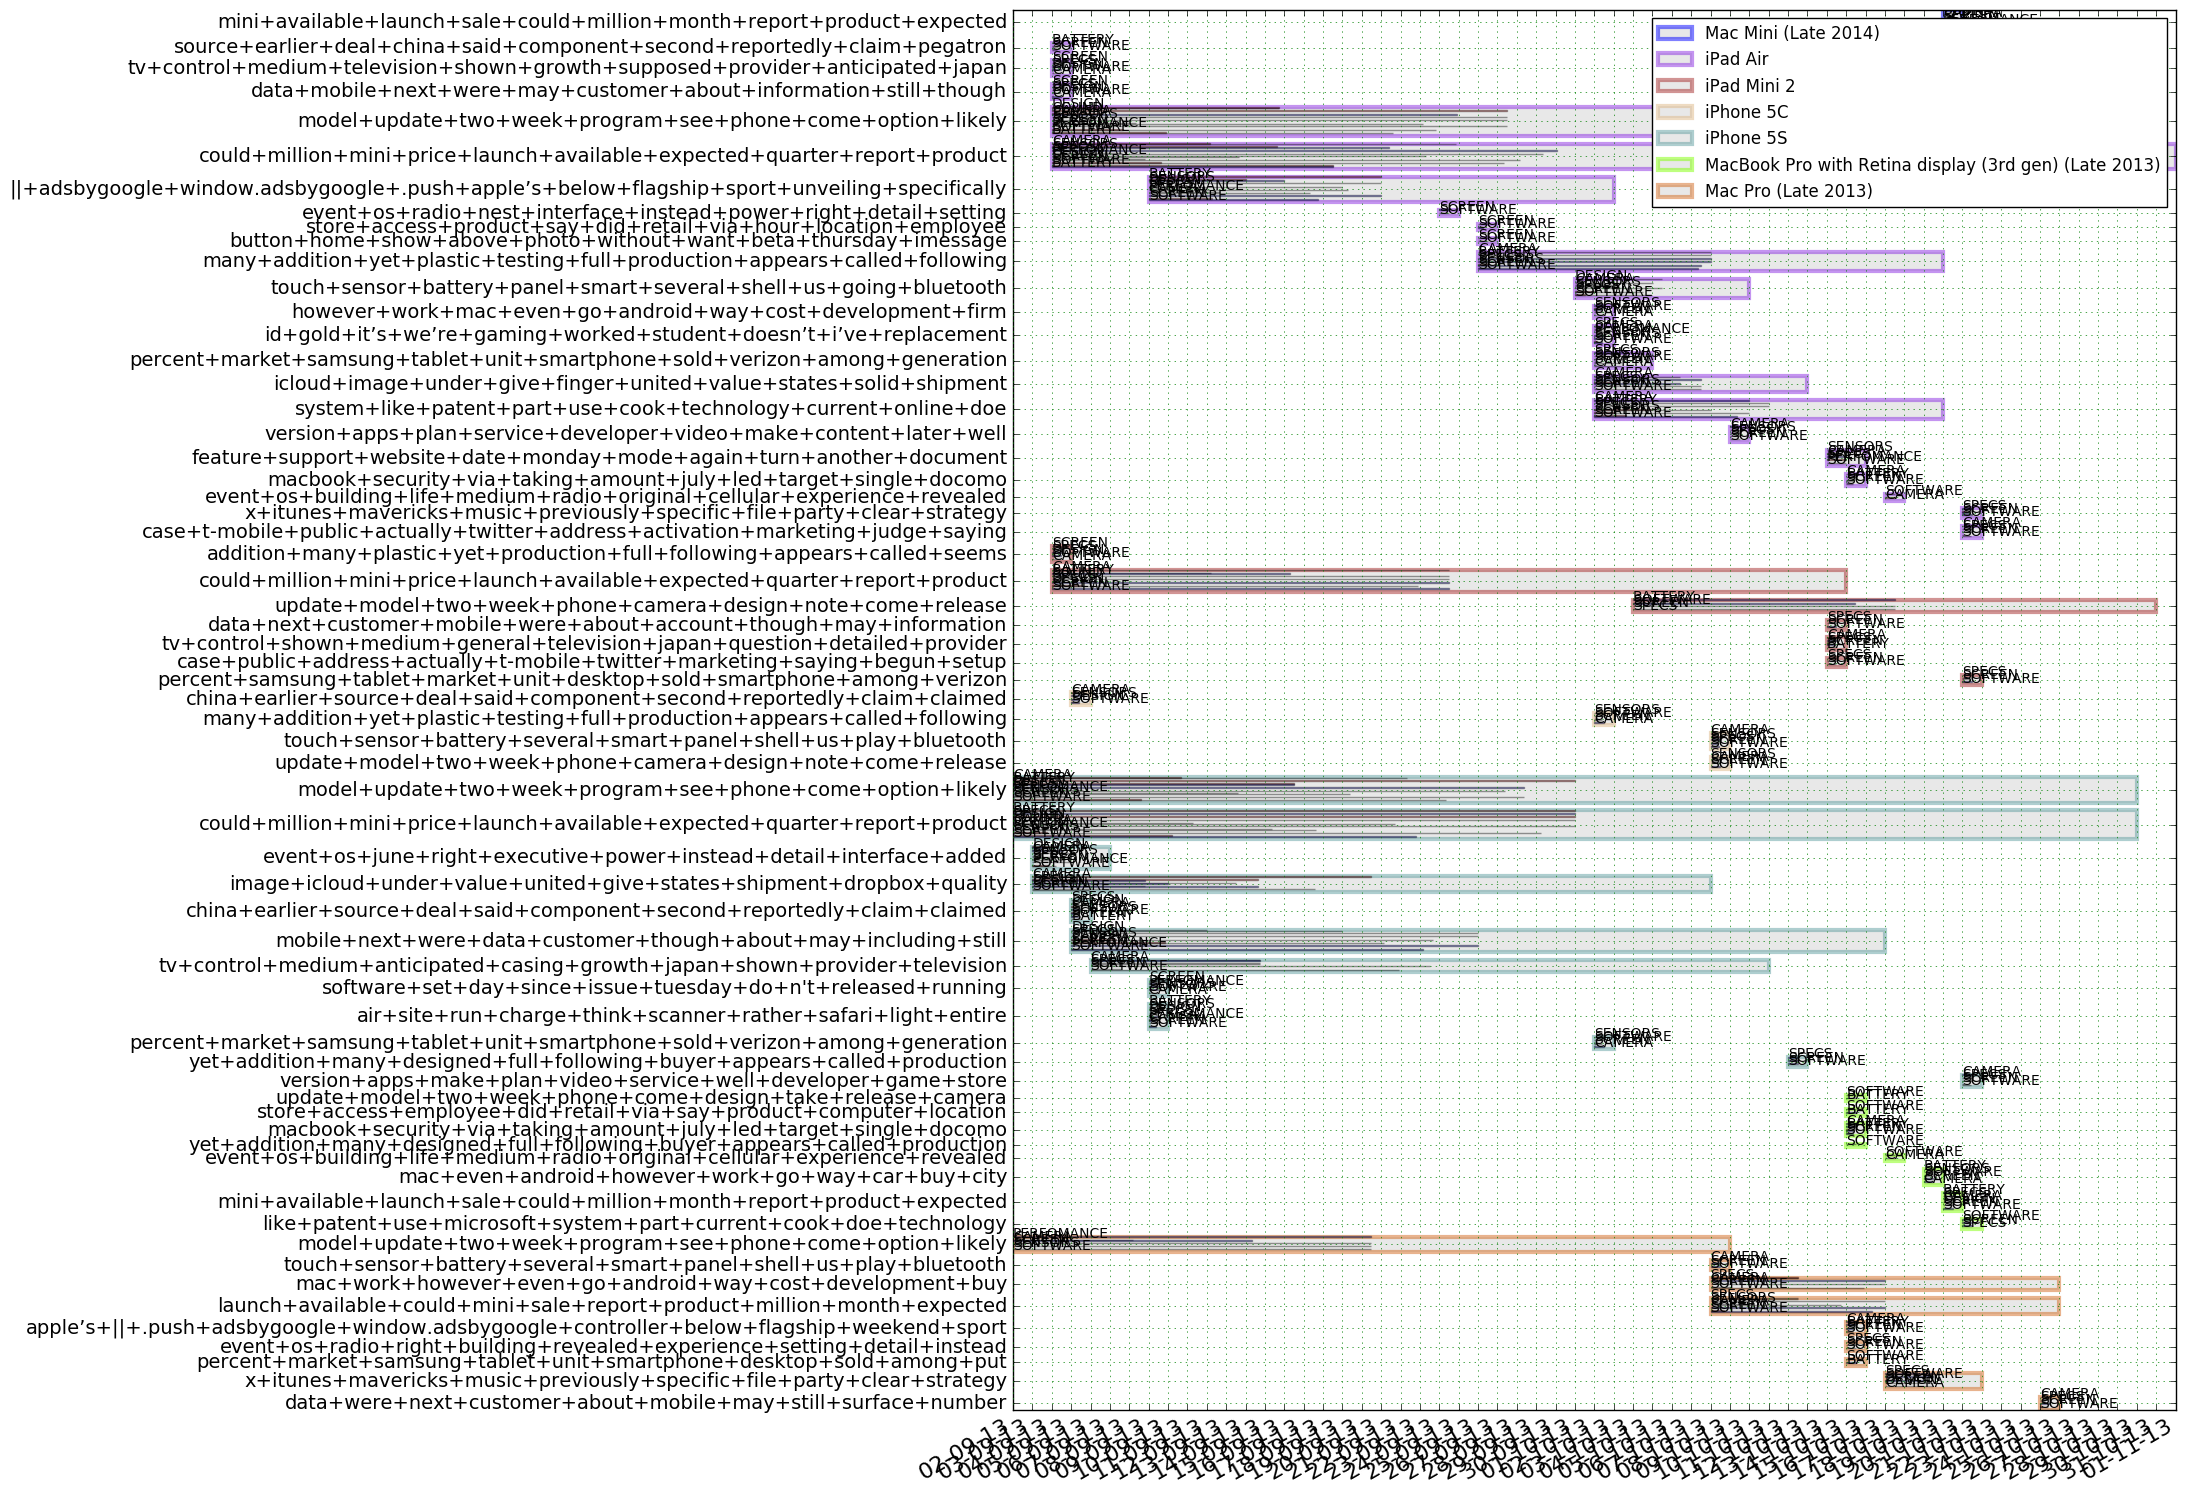

In [43]:
import matplotlib.pyplot as plt
from scipy.interpolate import spline
from matplotlib.lines import Line2D
from itertools import product
import matplotlib.font_manager as font_manager
import matplotlib.dates
from matplotlib.dates import MONTHLY, DAILY, DateFormatter, rrulewrapper, RRuleLocator

    
def visualize_events(product_data):
    fig = plt.figure(figsize=(15, 20))
    ax = fig.add_subplot(111)
    pos = []
    leg_colors = []
    legend = []
    topics = []
    id = 1
    perv_n = 0
    sc = {0: 'red', 1: 'blue'}
    shift = 0
#     product_data = sorted(product_data.items(), key=lambda x: (x[0], x[1].start_date, -x[1].end_date))
    for i, product in enumerate(product_data):
        if product_data[product]:
            for topic, event in sorted(product_data[product].items(), key=lambda x: (x[1].start_date, x[1].end_date)):
                if product not in legend:
                    leg = product
                    legend.append(product)
                    
                n_features = len(event.features)                    
                y_position = id + shift + n_features * 0.2
                shift += n_features * 0.4
                
                ax.barh(bottom= y_position, 
                        width=(event.end_date - event.start_date).days + 1, 
                        left=event.start_date, 
                        height=n_features * 0.4, 
                        align='center', 
                        edgecolor = colors[i].lower(), 
                        color  = 'lightgray', 
                        linewidth = 3,
                        alpha = 0.5, 
                        label = leg)
                
                f_id = 0
                for feature, sentiments in event.features.items():
                    y_pos = y_position - (n_features * 0.2) + 0.1 + f_id * 0.4
                    ax.text(event.start_date, y_pos, feature, fontsize=10, clip_on=True)  #TEXT
                    f_id += 1
                    for o, (sentiment, count) in enumerate(sentiments.items()): 
                        summed = sum(list(sentiments.values()))
                        ax.barh(bottom= y_pos - 0.1 + o * 0.1, #FEATURES
                                width=((event.end_date - event.start_date).days + 1)/2 * count / summed, 
                                left= event.start_date, 
                                height= 0.05, 
                                align='center', 
                                color= sc[sentiment], 
                                alpha = 0.4)

                
#                 ax.annotate('local max', xy=(event.start_date, (id*0.5)+1.0), xytext=(3, 1.5),arrowprops=dict(facecolor='black', shrink=0.05), clip_on=True)
                pos.append(y_position)
                topics.append(topic)
                id+=1
                leg = None
                perv_n = n_features
                
    locsy, labelsy = plt.yticks(pos, topics)
    plt.setp(labelsy, fontsize = 14)

    # Format the x-axis

    ax.axis('tight')
    ax.grid(color = 'g', linestyle = ':')

    ax.xaxis_date() #Tell matplotlib that these are dates...

    rule = rrulewrapper(DAILY, interval=1)
#     rule = rrulewrapper(MONTHLY, interval=1)
    loc = RRuleLocator(rule)
    formatter = DateFormatter("%d-%m-%y")
#     formatter = DateFormatter("%b-%y")

    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(formatter)
    
    labelsx = ax.get_xticklabels()
    plt.setp(labelsx, rotation=30, fontsize=16)

    # Format the legend
                
    ax.invert_yaxis()
    ax.legend(loc='upper right',  prop={'size':12})
    fig.autofmt_xdate()
#     plt.savefig('gantt.png')
    plt.show()
    
visualize_events(data)

In [44]:

GooglePlus
Twitter
RSS
THE CLOWERS GROUP
FOCUSING ON ANALYTICAL CHEMISTRY AT WASHINGTON STATE UNIVERSITY
GooglePlus Twitter RSS
SKIP TO CONTENT
HOME
RESEARCH
PUBLICATIONS
GROUP MEMBERS
CONTACT
LINKS
Gantt Charts in Matplotlib
  BY FEBRUARY 25, 2014 SCRIPTORIUM
GanttPlotLove it or hate it, the lack of a tractable options to create Gantt charts warrants frustration at times.  A recent post on Bitbucket provides a nice implementation using matplotlib and python as a platform.  In order to expand the basic functionality a few modifications enable a set of features that highlight the relative contributions of the team participants.  In the example provided above the broad tasks are indicated in yellow while the two inset bars (red:student and blue:PI) illustrate the percent effort.  See the source below for the details.

"""
Creates a simple Gantt chart
Adapted from https://bitbucket.org/DBrent/phd/src/1d1c5444d2ba2ee3918e0dfd5e886eaeeee49eec/visualisation/plot_gantt.py
BHC 2014
"""
 
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.dates
from matplotlib.dates import MONTHLY, DateFormatter, rrulewrapper, RRuleLocator
 
from pylab import *
 
def create_date(month,year):
"""Creates the date"""
 
date = dt.datetime(int(year), int(month), 1)
mdate = matplotlib.dates.date2num(date)
 
return mdate
 
# Data
 
pos = arange(0.5,5.5,0.5)
 
ylabels = []
ylabels.append('Hardware Design & Review')
ylabels.append('Hardware Construction')
ylabels.append('Integrate and Test Laser Source')
ylabels.append('Objective #1')
ylabels.append('Objective #2')
ylabels.append('Present at ASMS')
ylabels.append('Present Data at Gordon Conference')
ylabels.append('Manuscripts and Final Report')
 
effort = []
effort.append([0.2, 1.0])
effort.append([0.2, 1.0])
effort.append([0.2, 1.0])
effort.append([0.3, 0.75])
effort.append([0.25, 0.75])
effort.append([0.3, 0.75])
effort.append([0.5, 0.5])
effort.append([0.7, 0.4])
 
customDates = []
customDates.append([create_date(5,2014),create_date(6,2014)])
customDates.append([create_date(6,2014),create_date(8,2014),create_date(8,2014)])
customDates.append([create_date(7,2014),create_date(9,2014),create_date(9,2014)])
customDates.append([create_date(10,2014),create_date(3,2015),create_date(3,2015)])
customDates.append([create_date(2,2015),create_date(6,2015),create_date(6,2015)])
customDates.append([create_date(5,2015),create_date(6,2015),create_date(6,2015)])
customDates.append([create_date(6,2015),create_date(7,2015),create_date(7,2015)])
customDates.append([create_date(4,2015),create_date(8,2015),create_date(8,2015)])
 
task_dates = {}
for i,task in enumerate(ylabels):
task_dates[task] = customDates[i]
# task_dates['Climatology'] = [create_date(5,2014),create_date(6,2014),create_date(10,2013)]
# task_dates['Structure'] = [create_date(10,2013),create_date(3,2014),create_date(5,2014)]
# task_dates['Impacts'] = [create_date(5,2014),create_date(12,2014),create_date(2,2015)]
# task_dates['Thesis'] = [create_date(2,2015),create_date(5,2015)]
 
# Initialise plot
 
fig = plt.figure()
# ax = fig.add_axes([0.15,0.2,0.75,0.3]) #[left,bottom,width,height]
ax = fig.add_subplot(111)
 
# Plot the data
 
start_date,end_date = task_dates[ylabels[0]]
ax.barh(0.5, end_date - start_date, left=start_date, height=0.3, align='center', color='blue', alpha = 0.75)
ax.barh(0.45, (end_date - start_date)*effort[0][0], left=start_date, height=0.1, align='center', color='red', alpha = 0.75, label = "PI Effort")
ax.barh(0.55, (end_date - start_date)*effort[0][1], left=start_date, height=0.1, align='center', color='yellow', alpha = 0.75, label = "Student Effort")
for i in range(0,len(ylabels)-1):
labels = ['Analysis','Reporting'] if i == 1 else [None,None]
start_date,mid_date,end_date = task_dates[ylabels[i+1]]
piEffort, studentEffort = effort[i+1]
ax.barh((i*0.5)+1.0, mid_date - start_date, left=start_date, height=0.3, align='center', color='blue', alpha = 0.75)
ax.barh((i*0.5)+1.0-0.05, (mid_date - start_date)*piEffort, left=start_date, height=0.1, align='center', color='red', alpha = 0.75)
ax.barh((i*0.5)+1.0+0.05, (mid_date - start_date)*studentEffort, left=start_date, height=0.1, align='center', color='yellow', alpha = 0.75)
# ax.barh((i*0.5)+1.0, end_date - mid_date, left=mid_date, height=0.3, align='center',label=labels[1], color='yellow')
 
# Format the y-axis
 
locsy, labelsy = yticks(pos,ylabels)
plt.setp(labelsy, fontsize = 14)
 
# Format the x-axis
 
ax.axis('tight')
ax.set_ylim(ymin = -0.1, ymax = 4.5)
ax.grid(color = 'g', linestyle = ':')
 
ax.xaxis_date() #Tell matplotlib that these are dates...
 
rule = rrulewrapper(MONTHLY, interval=1)
loc = RRuleLocator(rule)
formatter = DateFormatter("%b '%y")
 
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
labelsx = ax.get_xticklabels()
plt.setp(labelsx, rotation=30, fontsize=12)
 
# Format the legend
 
font = font_manager.FontProperties(size='small')
ax.legend(loc=1,prop=font)


SyntaxError: invalid syntax (<ipython-input-44-932d84603ef2>, line 5)